# Full Orbit Experiment

In [1]:
import sys
sys.path.insert(0, '/home/emmanuel/projects/error_propagation/src')
sys.path.insert(0, '/home/emmanuel/projects/sakame/application/src/')

from single_orbit import FullOrbitExplore
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.externals import joblib

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from showprogress import showprogress

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data Parameters

In [2]:
orbits = [
    '20131001120859', 
    '20131001102955',
    '20131001015955',
    '20131001202954',
    '20131001185058',
    '20131001084755',
    '20131001152954',
    '20131001170858',
    '20131001221154', 
    '20131001135058', 
    '20131001034155', 
    '20131001070555', 
    '20131001052355']

day = orbits[0][:8]

## Experimental Parameters

In [12]:
random_state = 123        # for reproducibility
n_components = 50         # number of reduced dimensions for the data
noise_coefficient = 1.0   # Noise coefficient for the likelihood 
input_noise_level = None  # Input Noise Level

n_train_orbits = 6        # number of orbits to take training data from
train_size = 5000         # Number of training points to be used for training

k_folds = 2               # The number of folds for the cross validation grid search
rough_grid = False        # Rough grid search to define the search space
remove_poles = False      # Remove the North and South poles from the data
n_restarts = 0            # Number of restarts for the optimizer

n_test_orbits = len(orbits)         # number of orbits to perform testing on

## Get Data - Reduced + PCA

In [14]:
%%time 

print('Getting data...')
full_exp = FullOrbitExplore(
    random_state=random_state,
    n_components=n_components,
    input_noise_level=input_noise_level, 
    noise_coefficient=noise_coefficient, 
    n_train_orbits=n_train_orbits,
    n_test_orbits=n_test_orbits,
    train_size=train_size,
    rough_grid=rough_grid,
    n_restarts=n_restarts, 
    k_folds=k_folds)

data = full_exp.get_data()

Getting data...
Gathering data...
Orbit: 20131001120859
Orbit: 20131001102955
Orbit: 20131001015955
Orbit: 20131001202954
Orbit: 20131001185058
Orbit: 20131001084755
Getting error...
Finding PCA Transformation...
Transformating data...
Splitting into training and testing...
CPU times: user 8min 2s, sys: 4min 6s, total: 12min 8s
Wall time: 1min 31s


## Train GP Models

In [15]:
%%time

print('Training gps...')
full_exp.train_gps(data['xtrain'], data['ytrain'])

Training gps...
Found hyperparams...
28561 411 4.87
Fitting Standard GP...
291**2 * RBF(length_scale=573) + WhiteKernel(noise_level=8.36)
Training Results...
Fitting Error GP...
Training Results...
CPU times: user 21min 13s, sys: 19min 24s, total: 40min 37s
Wall time: 4min 10s


## Save Models

## Test GP Models

In [16]:
%%time

full_exp.test_gps()

Making predictions...
Loading data from orbit 20131001120859
Testing Results..
Transforming coordinates...
Saving data...
Loading data from orbit 20131001102955
Testing Results..
Transforming coordinates...
Saving data...
Loading data from orbit 20131001015955
Testing Results..
Transforming coordinates...
Saving data...
Loading data from orbit 20131001202954
Testing Results..
Transforming coordinates...
Saving data...
Loading data from orbit 20131001185058
Testing Results..
Transforming coordinates...
Saving data...
Loading data from orbit 20131001084755
Testing Results..
Transforming coordinates...
Saving data...
Loading data from orbit 20131001152954
Testing Results..
Transforming coordinates...
Saving data...
Loading data from orbit 20131001170858
Testing Results..
Transforming coordinates...
Saving data...
Loading data from orbit 20131001221154
Testing Results..
Transforming coordinates...
Saving data...
Loading data from orbit 20131001135058
Testing Results..
Transforming coordina

## Remove Bias

In [17]:
bias = full_exp.models['standard'].kernel_.get_params()['k2__noise_level']
print(bias)

8.361791220866982


## Visualization

### Temperatures & Predictions

In [214]:
def plot_map(dataset, variable, times):
    fig = plt.figure(figsize=(10, 6))

    ax = fig.add_subplot(111,  projection=ccrs.Robinson())

    plot_data = full_exp.xr_dataset[variable].isel(time=times) - 273.15
    plot_data.plot.imshow(ax=ax, transform=ccrs.PlateCarree(),
                          vmin=-10, vmax=30, cmap='RdBu_r', 
                          cbar_kwargs={'orientation': 'horizontal',
                                       'label': 'Temperature'})

    # ax1.scatter(data['lon_train'], data['lat_train'], transform=ccrs.PlateCarree(), s=0.1, color='green')

    ax.coastlines()
    # fig.savefig(fig_save_loc + 't1_bias.png')
    plt.show()
    return None

In [215]:
times_index = range(len(full_exp.xr_dataset.time.data))

In [216]:
times_index

range(0, 13)

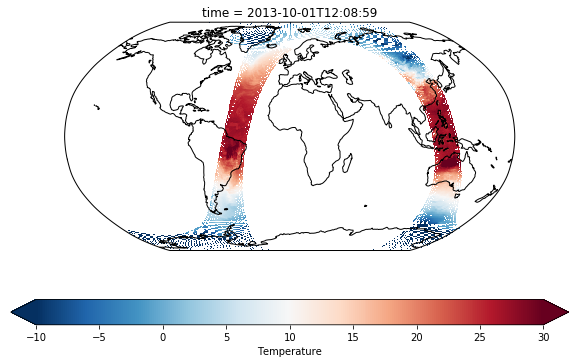

In [217]:
plot_map(full_exp.xr_dataset, 'temperature', times_index[0])

In [222]:
full_exp.xr_dataset

<xarray.Dataset>
Dimensions:       (lat: 359, lon: 720, time: 13)
Coordinates:
  * lon           (lon) float64 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
  * lat           (lat) float64 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time          (time) datetime64[ns] 2013-10-01T12:08:59 ... 2013-10-01T05:23:55
Data variables:
    temperature   (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    predictions   (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    epredictions  (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    std_dev       (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    estd_dev      (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan

In [1]:
import geoviews as gv
import geoviews.feature as gf

gv.extension('matplotlib')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [227]:
dataset = gv.Dataset(full_exp.xr_dataset, 
                     ['lon', 'lat', 'time'], 
                     'temperature', ccrs=ccrs.Robinson())
images = dataset.to(gv.Image)

images.opts(cmap='RdBu_r') * gf.coastline

In [2]:
interact(plot_map, dataset=full_exp.xr_dataset, variable=['temperature'], times=times_index)

NameError: name 'interact' is not defined

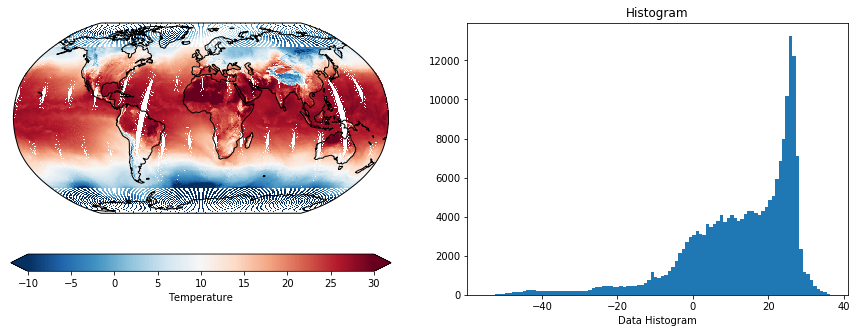

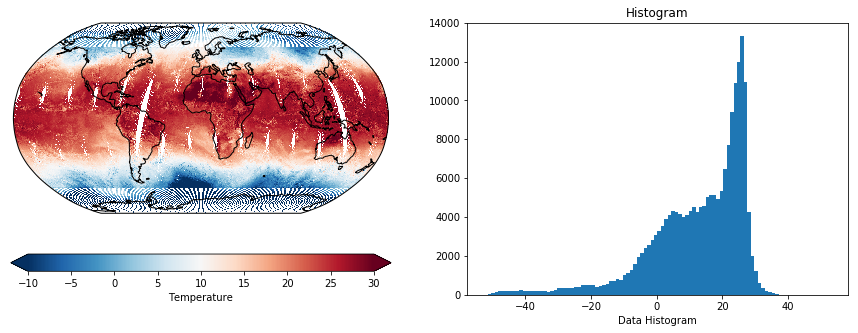

In [22]:
# Temperature
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121,  projection=ccrs.Robinson())
ax2 = fig.add_subplot(122)

plot_data = full_exp.xr_dataset.temperature.mean(dim='time') - 273.15

plot_data.plot.imshow(ax=ax1, transform=ccrs.PlateCarree(),
                      vmin=-10, vmax=30, cmap='RdBu_r', 
                      cbar_kwargs={'orientation': 'horizontal',
                                   'label': 'Temperature'})

# ax1.scatter(data['lon_train'], data['lat_train'], transform=ccrs.PlateCarree(), s=0.1, color='green')

ax1.coastlines()
plot_data.plot.hist(ax=ax2, bins=100)
ax2.set_xlabel('Data Histogram')
# fig.savefig(fig_save_loc + 't1_bias.png')
plt.show()

# Predictions
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121,  projection=ccrs.Robinson())
ax2 = fig.add_subplot(122)

plot_data = full_exp.xr_dataset.predictions.mean(dim='time') - 273.15
# data = data.sel(lat=slice(-60, 62))

plot_data.plot.imshow(ax=ax1, transform=ccrs.PlateCarree(),
                      vmin=-10, vmax=30, cmap='RdBu_r', 
                      cbar_kwargs={'orientation': 'horizontal',
                                   'label': 'Temperature'})
ax1.coastlines()
plot_data.plot.hist(ax=ax2, bins=100)
ax2.set_xlabel('Data Histogram')
# fig.savefig(fig_save_loc + 't1_bias.png')
plt.show()

In [24]:
full_exp.xr_dataset

<xarray.Dataset>
Dimensions:       (lat: 359, lon: 720, time: 13)
Coordinates:
  * lon           (lon) float64 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
  * lat           (lat) float64 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time          (time) datetime64[ns] 2013-10-01T12:08:59 ... 2013-10-01T05:23:55
Data variables:
    temperature   (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    predictions   (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    epredictions  (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    std_dev       (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    estd_dev      (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan

### Absolute Error and Standard Deviation

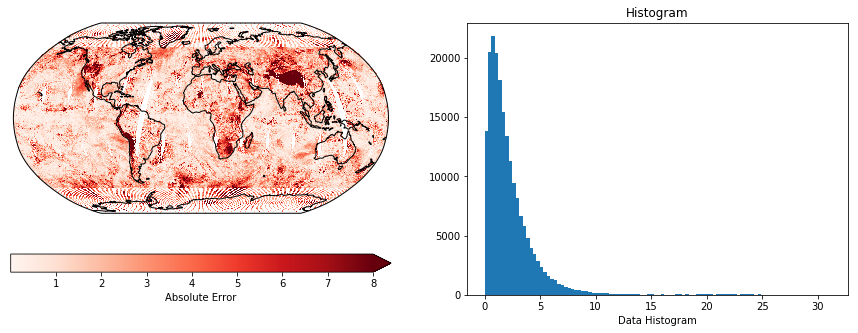

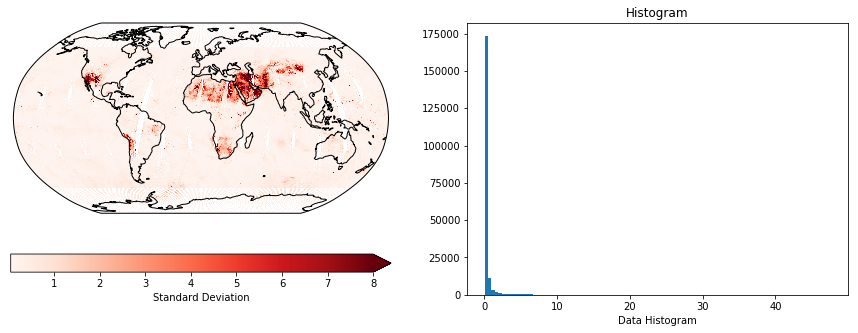

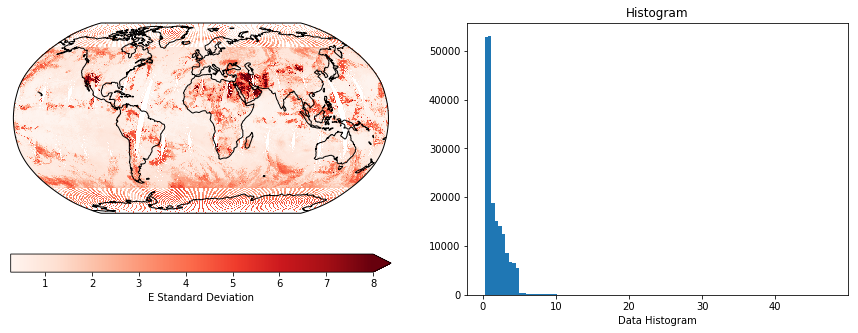

In [27]:
# ========================
# MEAN ABSOLUTE ERROR
# ========================
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121,  projection=ccrs.Robinson())
ax2 = fig.add_subplot(122)

plot_data = np.abs(full_exp.xr_dataset.temperature - full_exp.xr_dataset.predictions).mean(dim='time')
# data = data.sel(lat=slice(-60, 62))

plot_data.plot.imshow(ax=ax1, transform=ccrs.PlateCarree(),
                      vmax=8, cmap='Reds', 
                      cbar_kwargs={'orientation': 'horizontal',
                                   'label': 'Absolute Error'})
ax1.coastlines()
plot_data.plot.hist(ax=ax2, bins=100)
ax2.set_xlabel('Data Histogram')
# fig.savefig(fig_save_loc + 't1_bias.png')
plt.show()

# ========================
# STANDARD DEVIATION
# ========================
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121,  projection=ccrs.Robinson())
ax2 = fig.add_subplot(122)

plot_data = full_exp.xr_dataset.std_dev.mean(dim='time') - np.sqrt(bias)
# data = data.sel(lat=slice(-60, 62))

plot_data.plot.imshow(ax=ax1, transform=ccrs.PlateCarree(),
                      vmax=8, cmap='Reds', 
                      cbar_kwargs={'orientation': 'horizontal',
                                   'label': 'Standard Deviation'})
ax1.coastlines()
plot_data.plot.hist(ax=ax2, bins=100)
ax2.set_xlabel('Data Histogram')
# fig.savefig(fig_save_loc + 't1_bias.png')
plt.show()

# ========================
# Error STANDARD DEVIATION
# ========================
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121,  projection=ccrs.Robinson())
ax2 = fig.add_subplot(122)

plot_data = full_exp.xr_dataset.estd_dev.mean(dim='time') - np.sqrt(bias)
# data = data.sel(lat=slice(-60, 62))

plot_data.plot.imshow(ax=ax1, transform=ccrs.PlateCarree(),
                 vmax=8, cmap='Reds', 
                      cbar_kwargs={'orientation': 'horizontal',
                                   'label': 'E Standard Deviation'})
ax1.coastlines()
plot_data.plot.hist(ax=ax2, bins=100)
ax2.set_xlabel('Data Histogram')
# fig.savefig(fig_save_loc + 't1_bias.png')
plt.show()

## Model Error Statistics

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, pearsonr, kendalltau

In [102]:
def model_error(data, bias=0): 
    
    # Convert Data to Dataframe
    df = data.mean(dim='time').to_dataframe()
    df = df.dropna()
        
    df['error'] = np.abs(df['temperature'] - df['predictions'])
    df['std_dev'] = df['std_dev'] - bias
    df['estd_dev'] = df['estd_dev'] - bias
    stats = dict()
    # ====================
    # Model Stats
    # ====================
    stats['model_mae'] = mean_absolute_error(df['temperature'], df['predictions'])
    stats['model_mse'] = mean_squared_error(df['temperature'], df['predictions'])
    stats['model_rmse'] = np.sqrt(stats['model_mse'])
    stats['model_r2'] = r2_score(df['temperature'], df['predictions'])
    
    # ================
    # MAE
    # ================
    
    # MAE
    stats['mae'] = mean_absolute_error(df['error'], df['std_dev'])
    stats['emae'] = mean_absolute_error(df['error'], df['estd_dev'])
    
    
    # STD MAE
    stats['mae_std'] = np.std(np.abs(df['error'] - df['std_dev']))
    stats['emae_std'] = np.std(np.abs(df['error'] - df['estd_dev']))
    
    # ===================
    # Mean Squared Error
    # ===================
    
    # MSE
    stats['mse'] = mean_squared_error(df['error'], df['std_dev'])
    stats['emse'] = mean_squared_error(df['error'], df['estd_dev'])
    
    # STD MSE
    stats['mse_std'] = np.std((df['error'] - df['std_dev'])**2)
    stats['emse_std'] = np.std((df['error'] - df['estd_dev'])**2)
    
    # ========================
    # Root Mean Squared Error
    # ========================
    
    stats['rmse'] = np.sqrt(stats['mse'])
    stats['ermse'] = np.sqrt(stats['emse'])
    
    # STD RMSE
    stats['rmse_std'] = np.sqrt(stats['mse_std'])
    stats['ermse_std'] = np.sqrt(stats['emse_std'])
    
    # =======================
    # R2 Valuee
    # =======================
    
    stats['r2'] = r2_score(df['error'], df['std_dev'])
    stats['er2'] = r2_score(df['error'], df['estd_dev'])
    

    return stats

In [103]:
stats = model_error(full_exp.xr_dataset, bias=bias)

In [104]:
stats

{'model_mae': 1.9761266793685477,
 'model_mse': 9.645793106556125,
 'model_rmse': 3.105767716130124,
 'model_r2': 0.9555744668894399,
 'mae': 7.056636166709885,
 'emae': 5.790330646753825,
 'mae_std': 2.4178856010211534,
 'emae_std': 2.358974854780321,
 'mse': 55.64228476894336,
 'emse': 39.092691364222425,
 'mse_std': 60.11289477730225,
 'emse_std': 53.259705339414765,
 'rmse': 7.4593756286262565,
 'ermse': 6.252414842620603,
 'rmse_std': 7.753250594254145,
 'ermse_std': 7.29792472826452,
 'r2': -8.692568030184457,
 'er2': -5.809723434329883}

In [105]:
from ipywidgets import interact 
